# ELEC474 Project

In [ ]:
import cv2 as cv
import numpy as np
import os
import operator
import copy
import random
import math
import time
from cv2 import Stitcher
from matplotlib import pyplot as plt

In [ ]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

dirName1 = 'office2'
dirName2 = 'StJames'
dirName3 = 'WLH'

imgDescipt_1 = np.array((
"Left Key Point",
"Right Key Points"
))

imgDescipt_2 = np.array((
"Select point Output",
"Epipolar Line Output"
))

WINDOW_NAME1 = "1.2 Output Image_1"
WINDOW_NAME2 = "1.2 Output Image_2"
WINDOW_NAME3 = "1.3 Input left"
WINDOW_NAME4 = "1.3 Input Right"
WINDOW_NAME5 = "1.3 output 1"
WINDOW_NAME6 = "1.3 output 2"

Process_BarLength = 30

# Step 1

In [ ]:
class MatcheClass:
    def __init__(self, keypoint, descriptors, match):
        self.keypoints = keypoint
        self.descriptors = descriptors
        self.matchs = match
        self.img1 = []
        self.img2 = []
    
    def LoadImg1(self, img):
        self.img1 = img
    
    def LoadImg2(self, img):
        self.img2 = img
    
    def __eq__(self, other) -> bool:
        return self.__dict__ == other.__dict__
        

In [ ]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

def FetchingImgs(dirName):
    #list all the img file under dir 
    ls = []
    dir = os.getcwd()+'//'+dirName
    files = os.listdir(dir)
    for filename in files:
        # print(dir + os.sep + filename)

        if os.path.splitext(filename)[1] == '.jpg':
            ls.append(filename)
    if ls.count != 0:
        print("Detected: \n",ls)
    return ls

def ProgressionBarUpdate(current,overall):
    pctge = (current+1) / overall
    if pctge > 1:
        pctge = 1
    temp = int(round(Process_BarLength * pctge))
    print('\r%s%s%s%s'% ((temp)*'█',(Process_BarLength-temp)*'░',str(round(pctge*100)),'%'), end = ' ')


def ReadImgs(dirName, imgName):
    return cv.imread(os.getcwd()+'//'+dirName+'//'+imgName)

In [ ]:
def FindDescriptorAndKeyPoints(img, descriptor, flag): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = descriptor.detectAndCompute(imgGray,None)
    # imgKpOut = cv.drawKeypoints(imgKpOut,kp,0)
    return (kp,des)

def FlannBasedMatchLoweRatio(img1Param,img2Param,   
                            index_param,search_param,
                            kNum, ratio):
    # img1Kp = img1Param[1]
    # img2Kp = img2Param[1]
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(img1Param[1],img2Param[1],k = kNum)

    loweMatch = []
    # loweImg1Point = []
    # loweImg2Point = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])
            # loweImg1Point.append(img1Kp[m.queryIdx].pt) #NOTE: append requried left and rights points  
            # loweImg2Point.append(img2Kp[m.trainIdx].pt)

    # imgOut = cv.drawMatchesKnn(img1Param[0],img1Kp,img2Param[0],img2Kp,loweMatch,None,flags=2)
    return loweMatch

In [ ]:

def Matching(ds1, ds2, loweRatio):
    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    Matches = FlannBasedMatchLoweRatio(ds1, ds2,
                            index_params, search_params,
                            kNum = 2, ratio = loweRatio)  #NOTE: The ratio difference of lowe will result in different epiploar lines 
    
    return MatcheClass([ds1[0],ds2[0]], [ds1[1], ds2[1]], Matches)

In [ ]:

def MatchingFeaturesOfImages(dirName, matchMethod, descriptorMethod):
    matchMetric = 0
    imgList = []
    matchList = []
    descriptorList = []
    idx = 0

    # detect and extract features from the image
    if descriptorMethod == 'sift':
        descriptor = cv.xfeatures2d.SIFT_create()
    elif descriptorMethod == 'surf':
        descriptor = cv.xfeatures2d.SURF_create()
    elif descriptorMethod == 'brisk':
        descriptor = cv.BRISK_create()
    elif descriptorMethod == 'orb':
        descriptor = cv.ORB_create()
    
    print("Featching Images under Dir and creating descriptors for them")
    imgNameList = FetchingImgs(dirName)
    for imgName in imgNameList:
        idx += 1
        ProgressionBarUpdate(idx, len(imgNameList)+1)
        temp = ReadImgs(dirName, imgName)
        imgList.append(temp)
        descriptorList.append(FindDescriptorAndKeyPoints(temp, descriptor, flag=1))
        

    print("\nFind best Match for each pair of imgs")
    if matchMethod == 1: #if method equals one, then do match metric calculation to reorder the images, NOTE: its super performance costing
        imgCurIdx = 0
        length = len(imgList)
        imgListIdx = list(range(length))
        idx = 1
        
        for turnIdx in range(length-1):
            matchMetric = 0     
            # print(len(imgList))   
            # print("B", imgCurIdx)
            imgListIdx.remove(imgCurIdx)
            # print(len(imgList))

            for img2Idx in imgListIdx:
                idx += 1
                ProgressionBarUpdate(idx, ((length+1)*length/2))
                tempMatch = Matching(descriptorList[imgCurIdx], descriptorList[img2Idx], loweRatio=0.5)
                # print(len(tempMatch[2]))
                if len(tempMatch.matchs) > matchMetric:
                    # print("Update")
                    # print("P",matchMetric)
                    matchMetric = len(tempMatch.matchs)
                    # print("N",matchMetric)
                    bestImIdx = img2Idx
                    bestMatch = tempMatch
                    
            bestMatch.LoadImg1(imgList[imgCurIdx])
            bestMatch.LoadImg2(imgList[bestImIdx])
            imgCurIdx = bestImIdx
            matchList.append(bestMatch)
            # print(matchList)
    else:
        for imgIdx in range(len(imgList) - 1):
            ProgressionBarUpdate(imgIdx, len(imgList) - 1)
            tempMatch = Matching(descriptorList[imgIdx], descriptorList[imgIdx+1], loweRatio=0.5)
            tempMatch.LoadImg1(imgList[imgIdx])
            tempMatch.LoadImg2(imgList[imgIdx+1])
            matchList.append(tempMatch)
    return matchList

        

In [ ]:
# m1 = MatchingFeaturesOfImages(dirName1,matchMethod=0, descriptorMethod='sift')
m2 = MatchingFeaturesOfImages(dirName1,matchMethod=1, descriptorMethod='sift')

# print("m1", m1)
# print("m2", m2)

# print(len(m1))
# print(len(m2))
# for x,y in zip(m1, m2):
#     PltImg([x.img1, x.img2],["p1","p1"])
#     PltImg([y.img1, y.img2],["p2","p2"])

# Step 2

In [ ]:
def getPointTransformation(point, M):
    
    originM = list(np.array([point[0], point[1], 1.0]))
    M = np.linalg.inv(M)
    targetPoint = np.multiply(M, originM)
    # print("O",originM)
    # print("T",targetPoint)
    _x = targetPoint[0,0] / targetPoint[2,0]
    _y = targetPoint[1,0] / targetPoint[2,0]
    
    # print(_x, _y)
    return[_x,_y]



In [ ]:
class PercpectiveImgPair:
    def __init__(self, warpImg, M):
        self.warpImg = warpImg
        self.M = M

def PerspectiveTransformPairs(M: MatcheClass):
    
    imgSize = [M.img1.shape[1] + M.img2.shape[1], M.img1.shape[0]]

    #modify from lab, formatting data for estimateAffinePartial2D and filter out best matching points
    ref_pts = np.float32([M.keypoints[0][m[0].queryIdx].pt for m in M.matchs]).reshape(-1,1,2)
    img_pts = np.float32([M.keypoints[1][m[0].trainIdx].pt for m in M.matchs]).reshape(-1,1,2)

    M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) # Can be RANSAC or RHO or LMEDS
    M_inv = np.linalg.inv(M_p)
    # print("1",M_p)
    # print("2",M_inv)
    imgFinal = cv.warpPerspective(M.img2, M_p, imgSize)
    # PltImg([imgFinal],"warp")
    imgFinal[0:M.img2.shape[0], 0:M.img2.shape[1]] = M.img1

    originalPoint = M.keypoints[0][M.matchs[0][0].queryIdx].pt
    basePoint = M.keypoints[1][M.matchs[0][0].trainIdx].pt
    targetPoint = getPointTransformation(originalPoint, M_p)
    
    
    
    # imgFinal = np.copy(warpImg)
    
    return PercpectiveImgPair(imgFinal, M_p)
    # PltImg([imgFinal,M.img1, M.img2],["check1","img1","img2"])

In [ ]:
def PerspectiveTransform(M):
    imgSize = [M[0].img1.shape[1], M[0].img1.shape[0]]
    imgFinal = np.copy(M[0].img1)
    # print("first imgSize",imgSize)
    num = 0
    
    for mPair in M: 
        
        num += 1
        ProgressionBarUpdate(num, len(M))
        
        imgSize = [imgSize[0] + mPair.img2.shape[1], imgSize[1]]
        # print("Update imgSize",imgSize)
             
        #modify from lab, formatting data for estimateAffinePartial2D and filter out best matching points
        ref_pts = np.float32([mPair.keypoints[0][m[0].queryIdx].pt for m in mPair.matchs]).reshape(-1,1,2)
        img_pts = np.float32([mPair.keypoints[1][m[0].trainIdx].pt for m in mPair.matchs]).reshape(-1,1,2)

        M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) # Can be RANSAC or RHO or LMEDS
        warpImg = cv.warpPerspective(mPair.img2, M_p, imgSize)
        # print("size temp", tempImg.shape)
        # print("size final", imgFinal.shape)
        
        #Find the best matching point and it position after transformation
        originalPoint = mPair.keypoints[0][mPair.matchs[0][0].queryIdx].pt
        basePoint = mPair.keypoints[1][mPair.matchs[0][0].trainIdx].pt
        targetPoint = getPointTransformation(originalPoint, M_p)
        
        
        print("\nb",originalPoint)
        print("t", targetPoint)
    
        
        
        
        # PltImg([warpImg, mPair.img2],["warp", "original"])
        # warpImg[0:imgFinal.shape[0], 0:imgFinal.shape[1]] = mPair.img2 
        t1 = cv.circle(mPair.img2, tuple([int(originalPoint[1]), int(targetPoint[0])]), 100, (0,0,255), -1)
        t1 = cv.circle(mPair.img2, tuple([int(basePoint[1]), int(basePoint[0])]), 100, (0,255,0), -1)
        t2 = cv.circle(warpImg, tuple([int(originalPoint[1]), int(targetPoint[0])]), 100, (0,255,0), -1)
        t2 = cv.circle(warpImg, tuple([int(basePoint[1]), int(basePoint[0])]), 100, (0,0,255), -1)
        imgFinal = np.copy(warpImg)
        PltImg([t1, t2],["check1", "check2"])


In [ ]:
# PerspectiveTransform(m2)
PerspecPairList = []
for pairs in m2:
    temp = PerspectiveTransformPairs(pairs)
    # PltImg([temp.warpImg], "Warp")
    PerspecPairList.append(temp)


# Step 3

[9792, 3264]
(3264, 9792)
(3264, 9792, 3)


<Figure size 1800x1200 with 0 Axes>

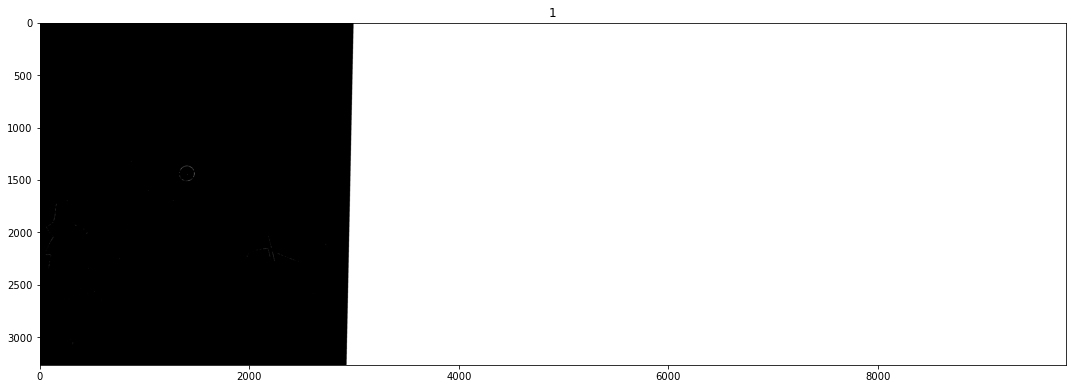

<Figure size 1800x1200 with 0 Axes>

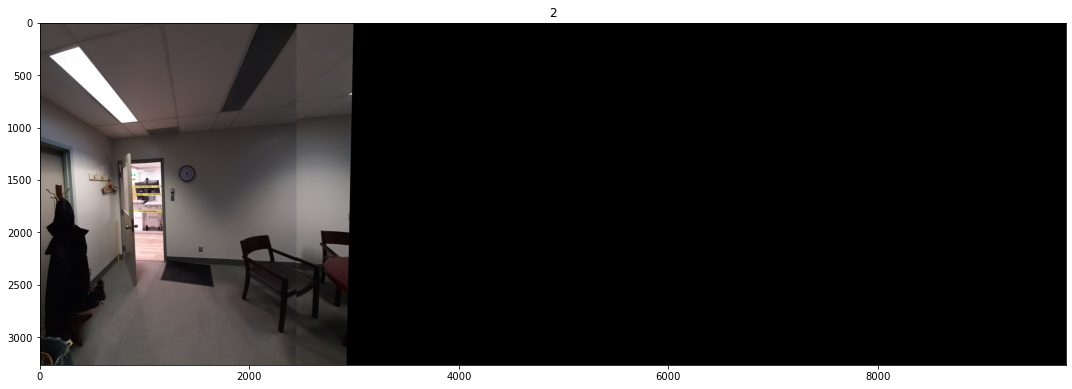

<Figure size 1800x1200 with 0 Axes>

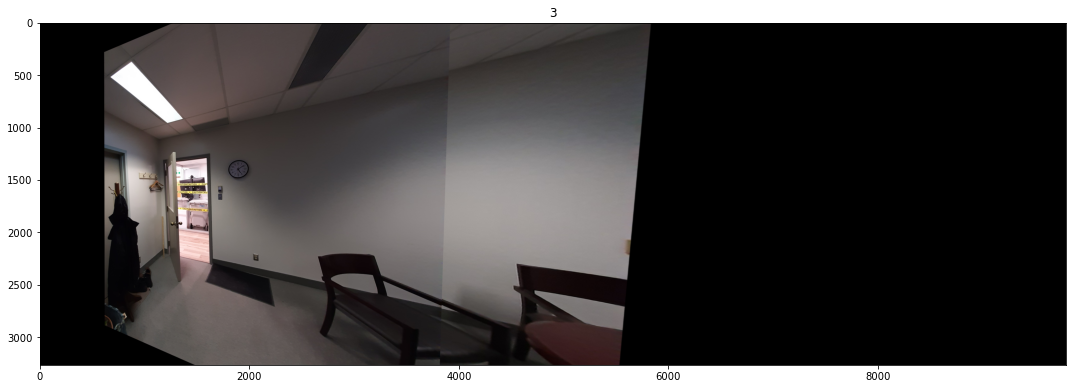

<Figure size 1800x1200 with 0 Axes>

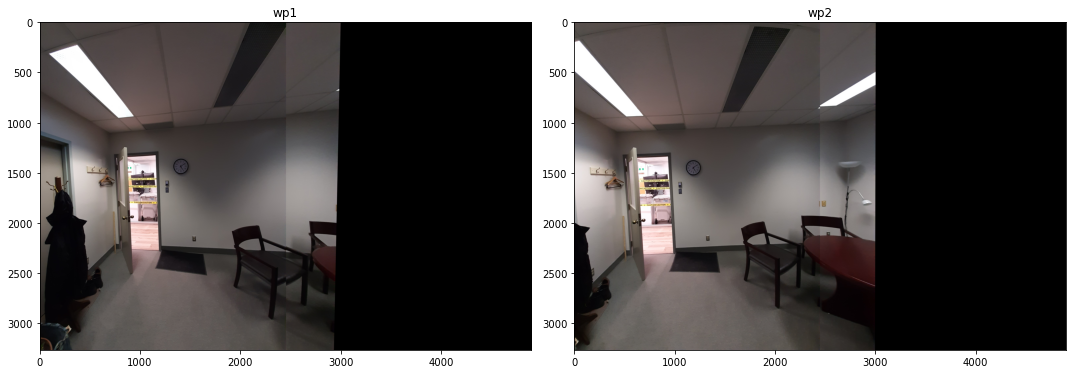

<Figure size 1800x1200 with 0 Axes>

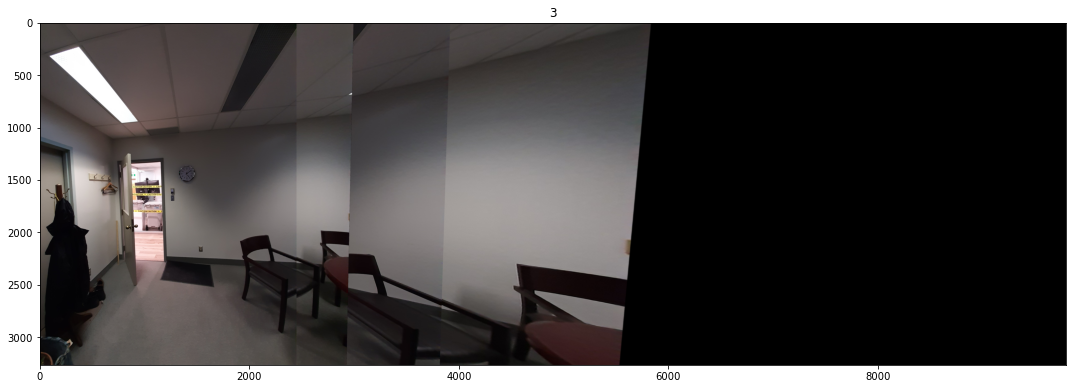

In [79]:
warp1 = PerspecPairList[0].warpImg
warp2 = PerspecPairList[1].warpImg

M1 = PerspecPairList[0].M
M2 = PerspecPairList[1].M

Mfinal = np.dot(M1, M2)
outSize = [warp1.shape[1]+warp2.shape[1], warp1.shape[0]]

# print("m1",M1)
# print("m2",M2)
# print("mf",Mfinal)
warpCombine = cv.warpPerspective(warp1, Mfinal, outSize)
new = np.zeros((outSize[1],outSize[0]))

mask = np.pad(cv.cvtColor(warp1,cv.COLOR_BGR2GRAY),((0,0),(0, warp2.shape[1])), mode='constant')
for rowpix in mask:
    # print(rowpix)
    for pix in range(len(rowpix)):
        temp = rowpix[pix]
        if temp != 0:
            rowpix[pix] = 0
        else:
            rowpix[pix] = 255
PltImg([mask],"1")
warpExtend = np.pad(warp1,((0,0),(0, warp2.shape[1]),(0,0)), mode='constant')
PltImg([warpExtend],"2")

# tempWarp = cv.resize(warp1, outSize)
print(outSize)
print(mask.shape)
print(warpCombine.shape)
PltImg([warpCombine],'3')
new = cv.copyTo(warpCombine, mask)

idx = np.where(new == 0)
idx = set(list(zip(idx[0],idx[1])))
for point in idx: 
    new[point] = warpExtend[point]



PltImg([warp1, warp2],["wp1","wp2"])    
# PltImg([final], "WHAT")
PltImg([new], "3")

In [ ]:
def MergedComposite(PerspecPairList :PercpectiveImgPair, MList):
    
    for pairs in PerspecPairList[1:]:
        

In [ ]:
a = np.ones((2,2))

print(a)

b = np.pad(a,((0,20),(0,0)),'constant')
print(b)